In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
import tensorflow as tf
import pandas as pd
from PIL import Image
import numpy as np
import zipfile
import os
import glob
import random
import sys

import skimage.io  #Used for imshow function
import skimage.transform  #Used for resize function
from skimage.morphology import label  #Used for Run-Length-Encoding RLE to create final submission
import matplotlib.pyplot as plt

from tensorflow.keras import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

In [ ]:
# Загрузка данных
data_dir = 'data_256/'
images_dir = 'images/'
masks_dir = 'masks/'
WIDTH = 256
HEIGHT = 256
CLASSES = 1

In [ ]:
import os
from PIL import Image
import numpy as np


def load_image(image_path):
    image = Image.open(data_dir + images_dir + image_path)  #.convert('L')  # Преобразуем в оттенки серого
    return np.array(image)


import numpy as np
from PIL import Image

def load_mask(mask_path):
    mask = Image.open(data_dir + masks_dir + mask_path).convert('L')  # Преобразуем в оттенки серого
    mask_array = np.array(mask)
    mask_float = mask_array.astype(float) / 255.0  # Преобразуем в тип float и нормализуем значения до диапазона [0, 1]
    return mask_float


In [ ]:
# # Подготовка данных
image_paths = sorted(os.listdir(data_dir + images_dir))

In [ ]:
print(image_paths)

['1.png', '10.png', '100.png', '101.png', '102.png', '103.png', '104.png', '105.png', '106.png', '107.png', '108.png', '109.png', '11.png', '110.png', '111.png', '112.png', '113.png', '114.png', '115.png', '116.png', '117.png', '118.png', '119.png', '12.png', '120.png', '121.png', '122.png', '123.png', '124.png', '125.png', '126.png', '127.png', '128.png', '129.png', '13.png', '130.png', '131.png', '132.png', '133.png', '134.png', '135.png', '136.png', '137.png', '138.png', '139.png', '14.png', '140.png', '141.png', '142.png', '143.png', '144.png', '145.png', '146.png', '147.png', '148.png', '149.png', '15.png', '150.png', '151.png', '152.png', '153.png', '154.png', '155.png', '156.png', '157.png', '158.png', '159.png', '16.png', '160.png', '161.png', '162.png', '163.png', '164.png', '165.png', '166.png', '167.png', '168.png', '169.png', '17.png', '170.png', '171.png', '172.png', '173.png', '174.png', '175.png', '176.png', '177.png', '178.png', '179.png', '18.png', '180.png', '181.png'

In [ ]:
from sklearn.model_selection import train_test_split

# Разделение данных на обучающую, валидационную и тестовую выборки
train_paths, test_paths = train_test_split(image_paths, test_size=0.2, random_state=42)
train_paths, valid_paths = train_test_split(train_paths, test_size=0.25, random_state=42)  # 0.25 * 0.8 = 0.2

# Проверка размеров выборок
print("Train samples:", len(train_paths))
print("Valid samples:", len(valid_paths))
print("Test samples:", len(test_paths))

Train samples: 358
Valid samples: 120
Test samples: 120


In [ ]:
train_images = [load_image(image_path) for image_path in train_paths]
train_masks = [load_mask(mask_path) for mask_path in train_paths]
train_images = np.array(train_images)
train_masks = np.array(train_masks)

In [ ]:
valid_images = [load_image(image_path) for image_path in valid_paths]
valid_masks = [load_mask(mask_path) for mask_path in valid_paths]
valid_images = np.array(valid_images)
valid_masks = np.array(valid_masks)

In [ ]:
test_images = [load_image(image_path) for image_path in test_paths]
test_masks = [load_mask(mask_path) for mask_path in test_paths]
test_images = np.array(test_images)
test_masks = np.array(test_masks)

In [ ]:

def unet_test_model(classes: int = 1):
    tf.keras.backend.clear_session()
    nb_filter = [32, 64, 128, 256, 512]
    # Build U-Net++ model
    inputs = Input((WIDTH, HEIGHT, 3))
    s = Lambda(lambda x: x / 255)(inputs)

    c1 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.5)(c1)
    c1 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c1)
    c1 = Dropout(0.5)(c1)
    p1 = MaxPooling2D((2, 2), strides=(2, 2))(c1)

    c2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.5)(c2)
    c2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c2)
    c2 = Dropout(0.5)(c2)
    p2 = MaxPooling2D((2, 2), strides=(2, 2))(c2)

    up1_2 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up12', padding='same')(c2)
    conv1_2 = concatenate([up1_2, c1], name='merge12', axis=3)
    c3 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv1_2)
    c3 = Dropout(0.5)(c3)
    c3 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(c3)
    c3 = Dropout(0.5)(c3)

    conv3_1 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(p2)
    conv3_1 = Dropout(0.5)(conv3_1)
    conv3_1 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv3_1)
    conv3_1 = Dropout(0.5)(conv3_1)
    pool3 = MaxPooling2D((2, 2), strides=(2, 2), name='pool3')(conv3_1)

    up2_2 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up22', padding='same')(conv3_1)
    conv2_2 = concatenate([up2_2, c2], name='merge22', axis=3)  #x10
    conv2_2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv2_2)
    conv2_2 = Dropout(0.5)(conv2_2)
    conv2_2 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv2_2)
    conv2_2 = Dropout(0.5)(conv2_2)

    up1_3 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up13', padding='same')(conv2_2)
    conv1_3 = concatenate([up1_3, c1, c3], name='merge13', axis=3)
    conv1_3 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv1_3)
    conv1_3 = Dropout(0.5)(conv1_3)
    conv1_3 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv1_3)
    conv1_3 = Dropout(0.5)(conv1_3)

    conv4_1 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(pool3)
    conv4_1 = Dropout(0.5)(conv4_1)
    conv4_1 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv4_1)
    conv4_1 = Dropout(0.5)(conv4_1)
    pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='pool4')(conv4_1)

    up3_2 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up32', padding='same')(conv4_1)
    conv3_2 = concatenate([up3_2, conv3_1], name='merge32', axis=3)  #x20
    conv3_2 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv3_2)
    conv3_2 = Dropout(0.5)(conv3_2)
    conv3_2 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv3_2)
    conv3_2 = Dropout(0.5)(conv3_2)

    up2_3 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up23', padding='same')(conv3_2)
    conv2_3 = concatenate([up2_3, c2, conv2_2], name='merge23', axis=3)
    conv2_3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv2_3)
    conv2_3 = Dropout(0.5)(conv2_3)
    conv2_3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv2_3)
    conv2_3 = Dropout(0.5)(conv2_3)

    up1_4 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up14', padding='same')(conv2_3)
    conv1_4 = concatenate([up1_4, c1, c3, conv1_3], name='merge14', axis=3)
    conv1_4 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv1_4)
    conv1_4 = Dropout(0.5)(conv1_4)
    conv1_4 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv1_4)
    conv1_4 = Dropout(0.5)(conv1_4)

    conv5_1 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(pool4)
    conv5_1 = Dropout(0.5)(conv5_1)
    conv5_1 = Conv2D(512, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv5_1)
    conv5_1 = Dropout(0.5)(conv5_1)

    up4_2 = Conv2DTranspose(nb_filter[3], (2, 2), strides=(2, 2), name='up42', padding='same')(conv5_1)
    conv4_2 = concatenate([up4_2, conv4_1], name='merge42', axis=3)  #x30
    conv4_2 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv4_2)
    conv4_2 = Dropout(0.5)(conv4_2)
    conv4_2 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv4_2)
    conv4_2 = Dropout(0.5)(conv4_2)

    up3_3 = Conv2DTranspose(nb_filter[2], (2, 2), strides=(2, 2), name='up33', padding='same')(conv4_2)
    conv3_3 = concatenate([up3_3, conv3_1, conv3_2], name='merge33', axis=3)
    conv3_3 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv3_3)
    conv3_3 = Dropout(0.5)(conv3_3)
    conv3_3 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv3_3)
    conv3_3 = Dropout(0.5)(conv3_3)

    up2_4 = Conv2DTranspose(nb_filter[1], (2, 2), strides=(2, 2), name='up24', padding='same')(conv3_3)
    conv2_4 = concatenate([up2_4, c2, conv2_2, conv2_3], name='merge24', axis=3)
    conv2_4 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv2_4)
    conv2_4 = Dropout(0.5)(conv2_4)
    conv2_4 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv2_4)
    conv2_4 = Dropout(0.5)(conv2_4)

    up1_5 = Conv2DTranspose(nb_filter[0], (2, 2), strides=(2, 2), name='up15', padding='same')(conv2_4)
    conv1_5 = concatenate([up1_5, c1, c3, conv1_3, conv1_4], name='merge15', axis=3)
    conv1_5 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv1_5)
    conv1_5 = Dropout(0.5)(conv1_5)
    conv1_5 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same')(conv1_5)
    conv1_5 = Dropout(0.5)(conv1_5)

    nestnet_output_4 = Conv2D(classes, (1, 1), activation='sigmoid', kernel_initializer='he_normal', name='output_4',
                              padding='same')(conv1_5)
    # output = Conv2D(
    #     filters=classes,
    #     kernel_size=(3, 3),
    #     padding='same',
    #     activation='softmax',
    #     use_bias=True,
    #     kernel_initializer='glorot_uniform',
    #     name='final_conv',
    # )(nestnet_output_4)

    # create keras model instance
    return Model(inputs=[inputs], outputs=
    [nestnet_output_4])


In [ ]:
LR = 0.0001


def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def bce_dice_loss(y_true, y_pred):
    return 0.5 * tf.keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

In [ ]:
import numpy as np

# Assuming you have a NumPy array called `arr` with shape [?, 256, 256]
arr = np.random.random([2, 3, 4])  # Example array

# Reshape the array to [?, 3, 4, 1]
reshaped_arr = np.reshape(arr, (arr.shape[0], arr.shape[1], arr.shape[2], 1))
print(arr)
print(reshaped_arr)

[[[0.79218017 0.11825064 0.83742319 0.87195906]
  [0.61437994 0.78414512 0.60912634 0.2168867 ]
  [0.05278764 0.15518914 0.19904508 0.37275297]]

 [[0.45477351 0.58959316 0.87752354 0.5892124 ]
  [0.84989063 0.1586259  0.34709309 0.22449012]
  [0.70686322 0.68330946 0.20677388 0.77873699]]]
[[[[0.79218017]
   [0.11825064]
   [0.83742319]
   [0.87195906]]

  [[0.61437994]
   [0.78414512]
   [0.60912634]
   [0.2168867 ]]

  [[0.05278764]
   [0.15518914]
   [0.19904508]
   [0.37275297]]]


 [[[0.45477351]
   [0.58959316]
   [0.87752354]
   [0.5892124 ]]

  [[0.84989063]
   [0.1586259 ]
   [0.34709309]
   [0.22449012]]

  [[0.70686322]
   [0.68330946]
   [0.20677388]
   [0.77873699]]]]


In [ ]:
from keras.losses import binary_crossentropy
import keras.backend as K


def dice_coeff(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score


def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss


def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)
    return loss


def weighted_dice_coeff(y_true, y_pred, weight):
    smooth = 1.
    w, m1, m2 = weight * weight, y_true, y_pred
    intersection = (m1 * m2)
    score = (2. * K.sum(w * intersection) + smooth) / (K.sum(w * m1) + K.sum(w * m2) + smooth)
    return score


def weighted_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # if we want to get same size of output, kernel size must be odd number
    if K.int_shape(y_pred)[1] == 128:
        kernel_size = 11
    elif K.int_shape(y_pred)[1] == 256:
        kernel_size = 21
    elif K.int_shape(y_pred)[1] == 512:
        kernel_size = 21
    elif K.int_shape(y_pred)[1] == 1024:
        kernel_size = 41
    else:
        raise ValueError('Unexpected image size')
    print(kernel_size)
    averaged_mask = K.pool2d(
        y_true, pool_size=(kernel_size, kernel_size), strides=(1, 1), padding='same', pool_mode='avg')
    border = K.cast(K.greater(averaged_mask, 0.005), 'float32') * K.cast(K.less(averaged_mask, 0.995), 'float32')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight += border * 2
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = 1 - weighted_dice_coeff(y_true, y_pred, weight)
    return loss


def weighted_bce_loss(y_true, y_pred, weight=0.5):
    # avoiding overflow
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))

    # https://www.tensorflow.org/api_docs/python/tf/nn/weighted_cross_entropy_with_logits
    loss = (1. - y_true) * logit_y_pred + (1. + (weight - 1.) * y_true) * \
           (K.log(1. + K.exp(-K.abs(logit_y_pred))) + K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)


import tensorflow.keras.backend as K

def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # Expand dimensions of y_true and y_pred
    y_true = K.expand_dims(y_true, axis=-1)
    y_pred = K.expand_dims(y_pred, axis=-1)

    # Остальной код функции...
    if K.int_shape(y_pred)[1] == 128:
        kernel_size = 11
    elif K.int_shape(y_pred)[1] == 256:
        kernel_size = 21
    elif K.int_shape(y_pred)[1] == 512:
        kernel_size = 21
    elif K.int_shape(y_pred)[1] == 1024:
        kernel_size = 41
    else:
        raise ValueError('Unexpected image size')
    averaged_mask = K.pool2d(
        y_true, pool_size=(kernel_size, kernel_size), strides=(1, 1), padding='same', pool_mode='avg')

    border = K.cast(K.greater(averaged_mask, 0.005), 'float32') * K.cast(K.less(averaged_mask, 0.995), 'float32')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight += border * 2
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = weighted_bce_loss(y_true, y_pred, weight) + (1 - weighted_dice_coeff(y_true, y_pred, weight))
    return loss

In [ ]:
import tensorflow as tf

# Определение метрики IoU
def iou(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou_score = intersection / (union + tf.keras.backend.epsilon())
    return iou_score

# Определение метрики Pixel Accuracy
def pixel_accuracy(y_true, y_pred):
    return tf.reduce_mean(tf.cast(tf.equal(y_true, tf.round(y_pred)), tf.float32))

# Определение метрики Dice Score
def dice_score(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred)
    dice = (2.0 * intersection) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + tf.keras.backend.epsilon())
    return dice

# Создание списка обратных вызовов с метриками
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(filepath='model.h5', save_best_only=True),
    tf.keras.callbacks.EarlyStopping(patience=3),
    tf.keras.callbacks.TensorBoard(log_dir='logs'),
    tf.keras.callbacks.LambdaCallback(on_epoch_end=lambda epoch, logs: print(f"IoU: {logs['iou']} - Pixel Accuracy: {logs['pixel_accuracy']} - Dice Score: {logs['dice_score']}"))
]


In [ ]:
import tensorflow as tf
from tensorflow.keras.metrics import IoU

model = unet_test_model(CLASSES)
model.compile(
              optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
              loss=weighted_bce_dice_loss,
              metrics=[iou, pixel_accuracy, dice_score],
            )

In [ ]:
NUM_EPOCHS=10

In [ ]:
all_history = []

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

while len(all_history) < NUM_EPOCHS:
    # Обучение модели
    history = model.fit(train_images,
                        train_masks,
                        validation_data=(valid_images, valid_masks),
                        epochs=1,
                        batch_size=8,
                        callbacks=callbacks_list)

    # Добавьте историю обучения в список
    all_history.append(history)
    print(NUM_EPOCHS - len(all_history))


45/45 [==============================] - 28s 609ms/step - loss: 1.0268 - iou: 0.2710 - pixel_accuracy: 0.8058 - dice_score: 0.4257 - val_loss: 1.0805 - val_iou: 0.2922 - val_pixel_accuracy: 0.7382 - val_dice_score: 0.4515
7
45/45 [==============================] - 28s 614ms/step - loss: 0.9627 - iou: 0.2836 - pixel_accuracy: 0.8134 - dice_score: 0.4408 - val_loss: 0.9953 - val_iou: 0.2957 - val_pixel_accuracy: 0.7494 - val_dice_score: 0.4557
6
45/45 [==============================] - 28s 632ms/step - loss: 0.9133 - iou: 0.2937 - pixel_accuracy: 0.8191 - dice_score: 0.4535 - val_loss: 0.9837 - val_iou: 0.2970 - val_pixel_accuracy: 0.7527 - val_dice_score: 0.4572
5
45/45 [==============================] - 29s 640ms/step - loss: 0.8679 - iou: 0.3094 - pixel_accuracy: 0.8276 - dice_score: 0.4718 - val_loss: 0.9109 - val_iou: 0.3183 - val_pixel_accuracy: 0.7973 - val_dice_score: 0.4820
4
45/45 [==============================] - 28s 629ms/step - loss: 0.7927 - iou: 0.3519 - pixel_accuracy: 0

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

while len(all_history) < 50:
    # Обучение модели
    history = model.fit(train_images,
                        train_masks,
                        validation_data=(valid_images, valid_masks),
                        epochs=1,
                        batch_size=8,
                        callbacks=callbacks_list)

    # Добавьте историю обучения в список
    all_history.append(history)
    print(50 - len(all_history))


45/45 [==============================] - 30s 649ms/step - loss: 0.6176 - iou: 0.4647 - pixel_accuracy: 0.8895 - dice_score: 0.6339 - val_loss: 1.1508 - val_iou: 0.3222 - val_pixel_accuracy: 0.8176 - val_dice_score: 0.4866
39
45/45 [==============================] - 29s 641ms/step - loss: 0.5900 - iou: 0.4822 - pixel_accuracy: 0.8950 - dice_score: 0.6499 - val_loss: 1.0655 - val_iou: 0.3010 - val_pixel_accuracy: 0.8588 - val_dice_score: 0.4618
38
45/45 [==============================] - 28s 630ms/step - loss: 0.5706 - iou: 0.4981 - pixel_accuracy: 0.8992 - dice_score: 0.6645 - val_loss: 1.0528 - val_iou: 0.3222 - val_pixel_accuracy: 0.8537 - val_dice_score: 0.4864
37
45/45 [==============================] - 28s 633ms/step - loss: 0.5437 - iou: 0.5142 - pixel_accuracy: 0.9029 - dice_score: 0.6786 - val_loss: 1.0833 - val_iou: 0.2969 - val_pixel_accuracy: 0.8584 - val_dice_score: 0.4571
36
45/45 [==============================] - 28s 624ms/step - loss: 0.5237 - iou: 0.5318 - pixel_accurac

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

while len(all_history) < 100:
    # Обучение модели
    history = model.fit(train_images,
                        train_masks,
                        validation_data=(valid_images, valid_masks),
                        epochs=1,
                        batch_size=8,
                        callbacks=callbacks_list)

    # Добавьте историю обучения в список
    all_history.append(history)
    print(100 - len(all_history))


45/45 [==============================] - 29s 644ms/step - loss: 0.2982 - iou: 0.7104 - pixel_accuracy: 0.9360 - dice_score: 0.8305 - val_loss: 1.3970 - val_iou: 0.3099 - val_pixel_accuracy: 0.7499 - val_dice_score: 0.4725
49
45/45 [==============================] - 29s 634ms/step - loss: 0.2966 - iou: 0.7118 - pixel_accuracy: 0.9361 - dice_score: 0.8316 - val_loss: 1.1976 - val_iou: 0.3492 - val_pixel_accuracy: 0.7900 - val_dice_score: 0.5169
48
45/45 [==============================] - 28s 629ms/step - loss: 0.2896 - iou: 0.7176 - pixel_accuracy: 0.9369 - dice_score: 0.8355 - val_loss: 1.2246 - val_iou: 0.3821 - val_pixel_accuracy: 0.8150 - val_dice_score: 0.5519
47
45/45 [==============================] - 28s 627ms/step - loss: 0.2890 - iou: 0.7182 - pixel_accuracy: 0.9369 - dice_score: 0.8359 - val_loss: 1.2278 - val_iou: 0.3586 - val_pixel_accuracy: 0.7974 - val_dice_score: 0.5269
46
45/45 [==============================] - 29s 636ms/step - loss: 0.2863 - iou: 0.7218 - pixel_accurac

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


IoU: 0.7265134453773499 - Pixel Accuracy: 0.9380109906196594 - Dice Score: 0.8415077328681946
45/45 [==============================] - 29s 650ms/step - loss: 0.2784 - iou: 0.7265 - pixel_accuracy: 0.9380 - dice_score: 0.8415 - val_loss: 0.7776 - val_iou: 0.4653 - val_pixel_accuracy: 0.8622 - val_dice_score: 0.6342
41
45/45 [==============================] - 28s 625ms/step - loss: 0.2771 - iou: 0.7288 - pixel_accuracy: 0.9381 - dice_score: 0.8430 - val_loss: 0.8175 - val_iou: 0.4514 - val_pixel_accuracy: 0.8557 - val_dice_score: 0.6211
40
45/45 [==============================] - 28s 633ms/step - loss: 0.2745 - iou: 0.7299 - pixel_accuracy: 0.9384 - dice_score: 0.8438 - val_loss: 0.7889 - val_iou: 0.4462 - val_pixel_accuracy: 0.8541 - val_dice_score: 0.6163
39
45/45 [==============================] - 29s 635ms/step - loss: 0.2735 - iou: 0.7309 - pixel_accuracy: 0.9385 - dice_score: 0.8444 - val_loss: 0.8308 - val_iou: 0.4272 - val_pixel_accuracy: 0.8424 - val_dice_score: 0.5978
38
45/45 

In [ ]:
history = all_history

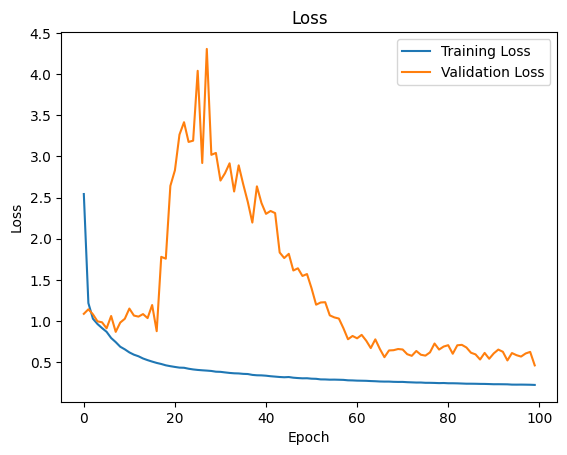

            IoU  Pixel Accuracy  Dice Score
Epoch                                      
0      0.105300        0.586249    0.189838
1      0.223051        0.772479    0.361944
2      0.271042        0.805755    0.425691
3      0.283575        0.813427    0.440784
4      0.293672        0.819062    0.453487
...         ...             ...         ...
95     0.771328        0.942676    0.870854
96     0.771247        0.942678    0.870782
97     0.771147        0.942803    0.870711
98     0.772608        0.942855    0.871663
99     0.774015        0.943058    0.872573

[100 rows x 3 columns]


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Создание пустых списков для сохранения значений метрик
loss = []
val_loss = []
iou = []
pixel_accuracy = []
dice_score = []

# Объединение значений метрик из всех историй
for h in history:
    loss.extend(h.history['loss'])
    val_loss.extend(h.history['val_loss'])
    iou.extend(h.history['iou'])
    pixel_accuracy.extend(h.history['pixel_accuracy'])
    dice_score.extend(h.history['dice_score'])

# Построение графика функции потерь
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Создание таблицы с метриками
metrics_df = pd.DataFrame({'IoU': iou, 'Pixel Accuracy': pixel_accuracy, 'Dice Score': dice_score})
metrics_df.index.name = 'Epoch'
print(metrics_df)

AttributeError: ignored

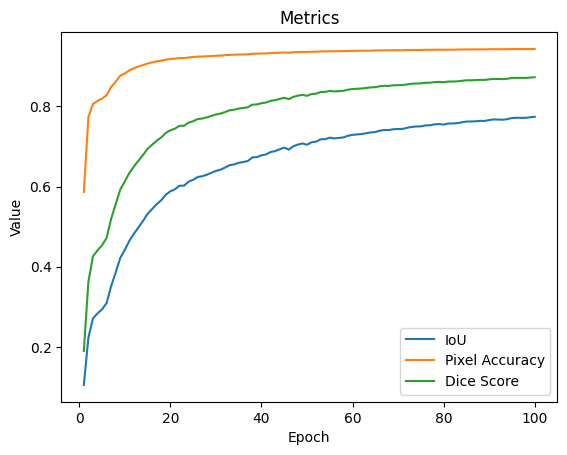

In [ ]:
# Построение графика метрик
epochs = range(1, 100 + 1)
plt.plot(epochs, iou, label='IoU')
plt.plot(epochs, pixel_accuracy, label='Pixel Accuracy')
plt.plot(epochs, dice_score, label='Dice Score')
plt.title('Metrics')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
# Создание таблицы с метриками каждые 3 эпохи
metrics_df = pd.DataFrame({'IoU': [], 'Pixel Accuracy': [], 'Dice Score': []})

for epoch in range(0, 100, 10):
    metrics_df.loc[epoch] = [iou[epoch], pixel_accuracy[epoch], dice_score[epoch]]

print(metrics_df)

         IoU  Pixel Accuracy  Dice Score
0   0.105300        0.586249    0.189838
10  0.464654        0.889480    0.633862
20  0.593030        0.918784    0.744236
30  0.641968        0.926511    0.781760
40  0.680019        0.931980    0.809387
50  0.710393        0.935988    0.830538
60  0.729912        0.938400    0.843781
70  0.743636        0.939771    0.852916
80  0.757063        0.941344    0.861647
90  0.767334        0.942426    0.868279


In [ ]:
tf.saved_model.save(model, 'model')

In [ ]:
result = model.predict(test_images)

4/4 [==============================] - 44s 6s/step


In [ ]:
print(result[0])

[[[1.3344333e-02]
  [2.5748634e-03]
  [1.2387136e-03]
  ...
  [2.1952183e-03]
  [4.3941741e-03]
  [2.1708895e-02]]

 [[3.5727965e-03]
  [4.1680312e-04]
  [1.3672413e-04]
  ...
  [3.0592064e-04]
  [6.8060268e-04]
  [5.8614914e-03]]

 [[1.6380777e-03]
  [1.2944789e-04]
  [3.4729404e-05]
  ...
  [8.9844543e-05]
  [2.3991117e-04]
  [3.1439732e-03]]

 ...

 [[1.6182053e-03]
  [1.3395886e-04]
  [3.6313464e-05]
  ...
  [6.2249936e-05]
  [1.8209155e-04]
  [2.3892045e-03]]

 [[4.7829808e-03]
  [6.2261731e-04]
  [2.8621513e-04]
  ...
  [3.2782642e-04]
  [9.8241039e-04]
  [5.8814590e-03]]

 [[2.2693664e-02]
  [6.3016918e-03]
  [2.8783632e-03]
  ...
  [4.7201253e-03]
  [6.5901051e-03]
  [2.7630907e-02]]]


In [ ]:
from PIL import Image
import numpy as np

# Предположим, что результат предсказания модели содержит вероятности пикселей для каждого класса
# Размерность результатов предсказания: (batch_size, HEIGHT, WIDTH, num_classes)

# Предположим, что результат предсказания модели содержит вероятности пикселей для каждого класса
# Размерность результатов предсказания: (batch_size, HEIGHT, WIDTH, num_classes)
num_classes = 7  # Количество классов (6 классов + 1 класс "ничего")
  # Порог для принятия решения о наличии объекта на пикселе
# Преобразование результатов предсказания в маски с максимальными значениями классов
part = 100
predicted_masks = result[:part]
threshold = 1.5 * np.mean(result)
# true_masks = test_masks
# Создание палитры цветов для каждого класса
palette = [
    (0, 0, 0),  # Класс "ничего" (черный цвет)
    (255, 0, 0),  # Класс 1 (красный цвет)
    (0, 255, 0),  # Класс 2 (зеленый цвет)
    (0, 0, 255),  # Класс 3 (синий цвет)
    (255, 255, 0),  # Класс 4 (желтый цвет)
    (255, 0, 255),  # Класс 5 (пурпурный цвет)
    (0, 255, 255),  # Класс 6 (бирюзовый цвет)
    (255, 255, 255)
]
#
# Создание изображений для каждого предсказанного класса
for i in range(min(predicted_masks.shape[0], part)):
    image = Image.new("RGB",
                      (
                          WIDTH, HEIGHT
                      )
                      )
    true = Image.new("RGB",
                      (
                          WIDTH, HEIGHT
                      )
                      )
    # true_mask = Image.new("RGB",
    #                   (
    #                       WIDTH, HEIGHT
    #                   )
    #                   )
    for y in range(
            HEIGHT
    ):
        for x in range(
                WIDTH
        ):
            if predicted_masks[i][y][x] >= threshold:
                class_index = 7
            else:
                class_index = 0
            # val = predicted_masks[i][x][y]
            image.putpixel((x, y), palette[class_index])  #(int(val * 255), int(val * 255), int(val * 255)))
            val = test_masks[i][y][x]
            true.putpixel((x,y), (int(255 * val), int(255 * val), int(255 * val)))
            # if true_masks[i][y][x] >= threshold:
            #     true_mask.putpixel((x, y), palette[7])
            # else:
            #     true_mask.putpixel((x, y), palette[0])
    image.save(f"result/predicted_image_{i}.png")
    true.save(f"result/predicted_image_{i}_true.png")

    # true_mask.save(f"result_small_5/predicted_image_{i}_true.png")



In [ ]:
print(test_masks[0])